# Regression models for synth parameters inference

TODO...

---
## Architecture overview

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
#%matplotlib widget
from IPython.display import Audio
import numpy as np

import torch
import importlib

import torchinfo

import data.build
import config
import model
from model import VAE, encoder, decoder, extendedAE, build
def reload_all_modules():
    importlib.reload(encoder)
    importlib.reload(decoder)
    importlib.reload(build)
    importlib.reload(model.layer)
    importlib.reload(model.VAE)
    importlib.reload(config)
reload_all_modules()

# A Dataset is now required to build models (to know the number of outputs)
full_dataset, dataset = data.build.get_full_and_split_datasets(config.model, config.train)
print(full_dataset)

encoder_model, decoder_model, ae_model, extended_ae_model = build.build_extended_ae_model(config.model, config.train, full_dataset.preset_indexes_helper)

print("AE model, without regression (Encoder/Decoder Architecture = {})".format(config.model.encoder_architecture))

#_ = torchinfo.summary(ae_model, input_size=config.model.input_tensor_size, depth=5, device='cpu')

[PresetIndexesHelper] 60 learnable parameters:     - 4.ALGORITHM: cat ([0, 1])    - 5.FEEDBACK: num (2)    - 6.OSC KEY SYNC: cat ([3, 4])    - 7.LFO SPEED: num (5)    - 8.LFO DELAY: num (6)    - 9.LFO PM DEPTH: num (7)    - 10.LFO AM DEPTH: num (8)    - 11.LFO KEY SYNC: cat ([9, 10])    - 12.LFO WAVE: cat ([11, 12, 13, 14, 15, 16])    - 14.P MODE SENS.: num (17)    - 15.PITCH EG RATE 1: num (18)    - 16.PITCH EG RATE 2: num (19)    - 17.PITCH EG RATE 3: num (20)    - 18.PITCH EG RATE 4: num (21)    - 19.PITCH EG LEVEL 1: num (22)    - 20.PITCH EG LEVEL 2: num (23)    - 21.PITCH EG LEVEL 3: num (24)    - 22.PITCH EG LEVEL 4: num (25)    - 23.OP1 EG RATE 1: num (26)    - 24.OP1 EG RATE 2: num (27)    - 25.OP1 EG RATE 3: num (28)    - 26.OP1 EG RATE 4: num (29)    - 27.OP1 EG LEVEL 1: num (30)    - 28.OP1 EG LEVEL 2: num (31)    - 29.OP1 EG LEVEL 3: num (32)    - 30.OP1 EG LEVEL 4: num (33)    - 31.OP1 OUTPUT LEVEL: num (34)    - 32.OP1 MODE: cat ([35, 36])    - 33.OP1 F COARSE: num (37) 

In [3]:
_ = torchinfo.summary(extended_ae_model, input_size=config.model.input_tensor_size, depth=5, device='cpu')

Layer (type:depth-idx)                                  Output Shape              Param #
├─BasicVAE: 1-1                                         [256, 2, 256]             --
|    └─SpectrogramEncoder: 2-1                          [256, 2, 256]             --
|    |    └─SpectrogramCNN: 3-1                         [256, 1024, 3, 4]         --
|    |    |    └─Sequential: 4-1                        [256, 1024, 3, 4]         --
|    |    |    |    └─Conv2D: 5-1                       [256, 8, 129, 174]        208
|    |    |    |    └─Conv2D: 5-2                       [256, 16, 65, 88]         2,096
|    |    |    |    └─Conv2D: 5-3                       [256, 32, 33, 45]         8,288
|    |    |    |    └─Conv2D: 5-4                       [256, 64, 17, 23]         32,960
|    |    |    |    └─Conv2D: 5-5                       [256, 128, 9, 12]         131,456
|    |    |    |    └─Conv2D: 5-6                       [256, 256, 5, 7]          525,056
|    |    |    |    └─Conv2D: 5-7      

---
---
# Constraints applied on presets

Visualization (and checks)

3136
Plot: learnable representation of the preset


(<Figure size 1180.8x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Preset UID=174223 (learnable parameters)'}, ylabel='Param. value'>)

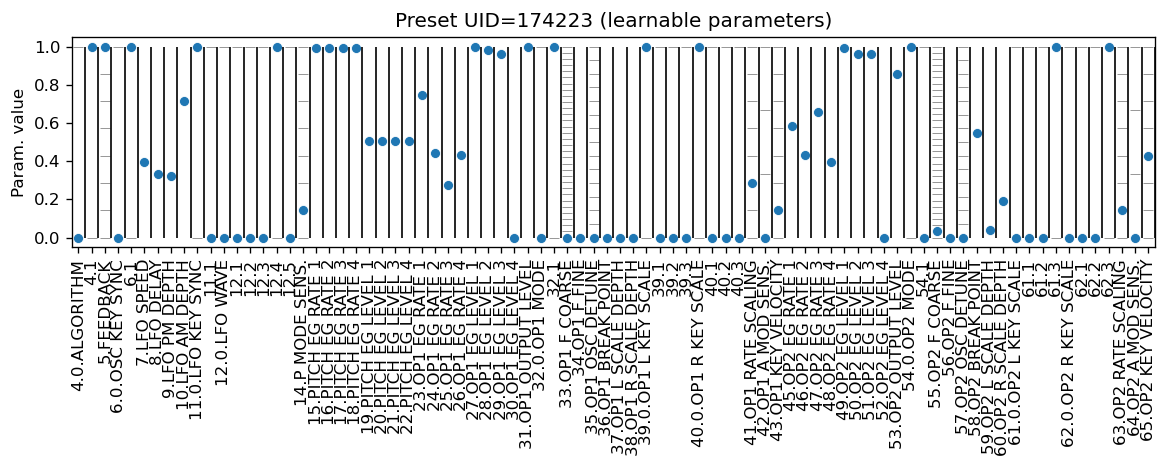

In [9]:
# TODO Display the true full preset and the preset reconstructed from the learnable preset (dev test)
dataset_index = np.random.randint(len(full_dataset))
learnable_preset = full_dataset[dataset_index][1]
print(dataset_index)
preset_UID = full_dataset[dataset_index][2][0].item()

import data.preset
importlib.reload(data.preset)
import utils.figures
importlib.reload(utils.figures)
print("Plot: learnable representation of the preset")
utils.figures.plot_synth_learnable_preset(learnable_preset, full_dataset.preset_indexes_helper, preset_UID=preset_UID)

Plot: full (VSTi-compatible) representation of the preset. Blue and orange faders must be identical.


(<Figure size 2232x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Preset UID=174223 (VSTi numerical parameters)'}, ylabel='Param. value'>)

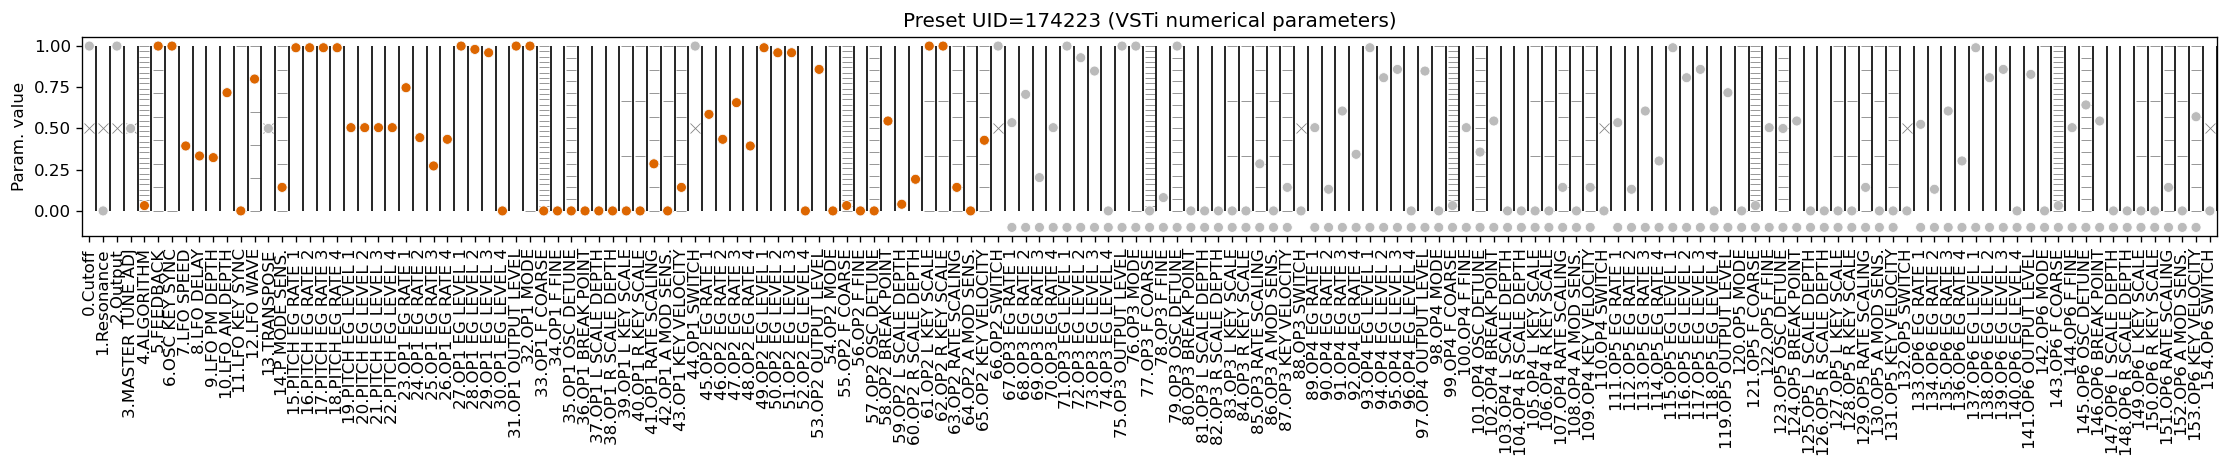

In [10]:
import data.preset
importlib.reload(data.preset)

print("Plot: full (VSTi-compatible) representation of the preset. Blue and orange faders must be identical.")
ref_full_preset = full_dataset.get_full_preset_params(preset_UID)
learnable_presets_class = data.preset.DexedPresetsParams(learnable_presets=torch.unsqueeze(learnable_preset, 0),
                                                         dataset=full_dataset)
utils.figures.plot_synth_preset_param(torch.squeeze(ref_full_preset.get_full(), 0),
                                      inferred_preset=torch.squeeze(learnable_presets_class.get_full(), 0),
                                      preset_UID=preset_UID, dataset=full_dataset)

---
# Synth parameters inference results

In [6]:
import data.build
import utils.config
import logs.logger
import utils.figures

root_path = Path(os.getcwd())
model_config, train_config = utils.config.get_config_from_file("/home/gwendal/Jupyter/nn-synth-interp/saved/ExtVAE0/02_vstcat_0.2loss/config.json")
#train_config.minibatch_size = 1  # Smaller batch size for evaluation - comment to plot batch stats

# Datasets and Dataloaders - Copied from train.py
full_dataset, dataset = data.build.get_full_and_split_datasets(model_config, train_config)
dataloader = data.build.get_split_dataloaders(train_config, full_dataset, dataset, persistent_workers=False)
dataloader_iter = iter(dataloader['validation'])

# Build model from saved checkpoint
checkpoint = logs.logger.get_model_last_checkpoint(root_path, model_config)
_, _, _, extended_ae_model = model.build.build_extended_ae_model(model_config, train_config, full_dataset.preset_indexes_helper)
extended_ae_model.load_state_dict(checkpoint['ae_model_state_dict'])  # loaded on GPU
extended_ae_model = extended_ae_model.cpu()
_ = extended_ae_model.eval()

[PresetIndexesHelper] 60 learnable parameters:     - 4.ALGORITHM: cat ([0, 1])    - 5.FEEDBACK: num (2)    - 6.OSC KEY SYNC: cat ([3, 4])    - 7.LFO SPEED: num (5)    - 8.LFO DELAY: num (6)    - 9.LFO PM DEPTH: num (7)    - 10.LFO AM DEPTH: num (8)    - 11.LFO KEY SYNC: cat ([9, 10])    - 12.LFO WAVE: cat ([11, 12, 13, 14, 15, 16])    - 14.P MODE SENS.: num (17)    - 15.PITCH EG RATE 1: num (18)    - 16.PITCH EG RATE 2: num (19)    - 17.PITCH EG RATE 3: num (20)    - 18.PITCH EG RATE 4: num (21)    - 19.PITCH EG LEVEL 1: num (22)    - 20.PITCH EG LEVEL 2: num (23)    - 21.PITCH EG LEVEL 3: num (24)    - 22.PITCH EG LEVEL 4: num (25)    - 23.OP1 EG RATE 1: num (26)    - 24.OP1 EG RATE 2: num (27)    - 25.OP1 EG RATE 3: num (28)    - 26.OP1 EG RATE 4: num (29)    - 27.OP1 EG LEVEL 1: num (30)    - 28.OP1 EG LEVEL 2: num (31)    - 29.OP1 EG LEVEL 3: num (32)    - 30.OP1 EG LEVEL 4: num (33)    - 31.OP1 OUTPUT LEVEL: num (34)    - 32.OP1 MODE: cat ([35, 36])    - 33.OP1 F COARSE: num (37) 

In [7]:
x_in, u_in, sample_info, labels = next(dataloader_iter)
with torch.no_grad():
    z_mu_logvar, z_sampled, x_out, u_out = extended_ae_model(x_in)

In [ ]:
# TODOOOO plot batch error

In [8]:
importlib.reload(utils.figures)
# Plots about batch element 0 only? Or random
item_batch_index = np.random.randint(0, x_in.shape[0])

preset_UID = sample_info[item_batch_index][0].item()
midi_note, midi_velocity = sample_info[item_batch_index][1].item(), sample_info[item_batch_index][2].item()
# Compute corresponding full presets
preset_in = full_dataset.get_preset_params(preset_UID)
# We apply the distorsion to preset_in as well (to properly view the algorithm inference)
preset_in_distorted = full_dataset.apply_params_learning_distortion(preset_in)
preset_out = full_dataset.inferred_to_vst_preset(u_out[0], revert_distortion=False)

utils.figures.plot_synth_preset_param(preset_in_distorted, preset_out,
                                      preset_UID=preset_UID, dataset=full_dataset)

AttributeError: 'DexedDataset' object has no attribute 'get_preset_params'

In [34]:
x_wav_original, Fs = full_dataset._render_audio(preset_in, midi_note, midi_velocity)
Audio(x_wav_original, rate=Fs)

In [35]:
# Output using model-inferred params
preset_out = full_dataset.inferred_to_vst_preset(u_out[0], revert_distortion=True)
x_wav_inferred, Fs = full_dataset._render_audio(preset_out, midi_note, midi_velocity)
Audio(x_wav_inferred, rate=Fs)

In [36]:
# Manual modifications of inferred preset - to try to understand what is happening...
import copy
importlib.reload(utils.figures)
preset_out_modified = copy.deepcopy(preset_out)
idx_to_set = [4]  # Same algorithm
idx_to_set = [14]  # Pitch modulation (mod wheel unused)
for i in range(6):  # For each operator
    idx_to_set.append(33 + 22*i)  # F COARSE - bcp d'effet sur la tonalité
    idx_to_set.append(34 + 22*i)  # F FINE - bcp d'effet sur la tonalité
    idx_to_set.append(39 + 22*i)  # L KEY SCALE - change peu
    idx_to_set.append(40 + 22*i)  # R KEY SCALE - change peu
    idx_to_set.append(43 + 22*i)  # KEY VELOCITY
    idx_to_set.append(42 + 22*i)  # Amplitude modulation sensitivity (mod wheel unused)
    if False:  # set ground-truth EG levels and rate
        # Enveloppe EG LevelX
        idx_to_set.append(27 + 22*i)
        idx_to_set.append(28 + 22*i)
        idx_to_set.append(29 + 22*i)
        idx_to_set.append(30 + 22*i)
        # Enveloppe EG RateX
        idx_to_set.append(23 + 22*i)
        idx_to_set.append(24 + 22*i)
        idx_to_set.append(25 + 22*i)
        idx_to_set.append(26 + 22*i)
    
preset_out_modified[idx_to_set] = preset_in[idx_to_set]
utils.figures.plot_synth_preset_param(preset_in, preset_out_modified, preset_UID=preset_UID,
                                      dataset=full_dataset)
x_wav_inferred, Fs = full_dataset._render_audio(preset_out_modified, midi_note, midi_velocity)
Audio(x_wav_inferred, rate=Fs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Full-dataset plots

Parameters error (to identify issues with model inference). Now available in Tensorboard.